
# **Clase 2**: Recommender system basado en contenido

Diego Galeano, Ph.D.

Parcialmente basada en la version en ingles: https://colab.research.google.com/drive/1Q68oZBb35VcqYlLiVPO976d6kCvEO1Xt#scrollTo=gmznKTJG5kGf

<a id='RS'></a>
# Que es un sistema de recomendacion?

Sistema de recomendación es el nombre que se le da a cualquier software diseñado para recomendarle objetos (para comprar, hacer clic o mirar) que le resulten atractivos con una alta probabilidad. El desarrollo de tales sistemas se convirtió en un tema candente para los desarrolladores de software y los ingenieros de aprendizaje automático en los últimos años. Un sistema de recomendación de buen rendimiento puede tener un impulso significativo en las ganancias que obtienen muchas plataformas en línea.

Hoy en día, muchos de nosotros interactuamos con sistemas de recomendación a diario. Si tiene una cuenta en Amazon o Netflix o muchos servicios en línea similares, es posible que haya recibido sugerencias que a menudo se ajustan a sus intereses. Esto puede variar desde una película sugerida por Netflix o muy diversos productos sugeridos por Amazon. Los anuncios dirigidos en Facebook o los anuncios emergentes dirigidos en su navegador también son otros ejemplos de aplicaciones de sistemas de recomendación. Casi ninguna persona recibe exactamente los mismos anuncios o sugerencias en una plataforma en línea. Todas estas sugerencias y anuncios personalizados utilizan sistemas de recomendación para encontrar la que mejor se adapte a sus intereses de acuerdo con sus calificaciones, compras o clics anteriores.

Uno de los enfoques más sencillos para encontrar una recomendación adecuada para los usuarios de una plataforma es el enfoque * Sistema de recomendación basado en contenido *. Este método determina un valor de calificación $ R_ {ij} $ para un usuario específico $ u_i $ que se otorga a un objeto específico $ o_j $ mediante el uso de un vector de características $ \vec{x}_i $ para el usuario $i$ -ésimo y un vector de características para el $j$-ésimo objeto $\vec{\theta}_j$. 

El mayor problema con tales algoritmos es que necesitamos conocer las características importantes que tienen impacto en las decisiones que toma cada usuario. Es realmente difícil encontrar este conjunto de características. Incluso si podemos definir un conjunto razonablemente bueno de características importantes, el próximo gran desafío es calificar estas características para cada elemento y usuario. A menudo, dicha información no está disponible o no es práctico extraerla por completo. Aunque muchas plataformas tienen acceso a cierta información sobre los usuarios que se puede utilizar como características como la edad, el género, etc., a menudo esta información no es suficiente para construir vectores de características suficientemente buenos.



$\color{green}{\text{Antes de comenzar}}$ vamos a correr la siguiente celda que tiene todas las librerias requeridas para este notebook.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np
import copy
import random
import scipy.io
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
    
# If you want to have direct access to the datasets and codes you can clone the following github repository    
! git clone https://github.com/saminehbagheri/Recommender-System.git
%cd Recommender-System  

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Cloning into 'Recommender-System'...
remote: Enumerating objects: 66, done.
remote: Total 66 (delta 0), reused 0 (delta 0), pack-reused 66
Unpacking objects: 100% (66/66), done.
/content/Recommender-System


<a id='CBRS'></a>
# Ejemplo de un sistema de recomendacion basado en contenido

Comencemos con un ejemplo simple para el ** enfoque basado en contenido **.

Imaginemos un pequeño problema en el que solo tenemos tres usuarios: Bob, Alicia y Pedro. Si asumimos que las únicas características importantes para estos usuarios (por supuesto, en un escenario muy simplificado) son cuánto es una película (1) romántica, (2) comedia o (3) acción, entonces podemos asumir un vector de características de tamaño 3 para cada usuario. $ \vec{x}_i = \{interes~en~romance,interes~en~comedia,interes~en~accion\}$.

Tuvimos la oportunidad de pedirles a nuestros tres usuarios que nos informaran sobre sus intereses completando sus vectores de características. Podrían haber calificado cada elemento con 0 si no tienen ningún interés, 1 si realmente les importa esa característica y 0.5 si sus sentimientos están en algún punto intermedio.

A Alicia simplemente le gustan las películas románticas y no le gusta mucho la acción y la comedia, por lo que su vector de características se ve así: $ \vec{x_a} = [1,0,0]$. A Bob le gustan las películas de comedia y no le gustan el romance ni la acción en absoluto $ \vec{x_b} = [0,1,0] $. A Pedro no le gusta el romance, pero ama la acción y no le importa si hay sentido del humor en las películas, por lo que su vector de características se ve así: $ \vec{x_p} = [0,0.5,1] $. Apilando todos estos vectores de características juntos tendremos la **matriz de características** del usuario.

In [3]:
USER=pd.DataFrame([( [1, 0, 0]), ( [0, 1, 0]), ( [0, 0.5, 1])], 
                  columns=['Alicia','Bob','Pedro'],
                  index=['Romance','Comedia','Accion']);
print(USER)

         Alicia  Bob  Pedro
Romance       1  0.0      0
Comedia       0  1.0      0
Accion        0  0.5      1


Tenemos tres películas en nuestro sistema Titanic, Terminator y Home Alone y queremos averiguar cuál es la mejor recomendación para cada usuario. Para hacer eso, necesitamos definir un vector de características para cada película. Le pedimos a algún experto que lo haga por nosotros. Titanic es una película muy romántica y no es divertida ni de acción en absoluto, así que es justo si calificamos su vector de características como $ \vec{\theta}_{Titanic} = [1,0,0] $. Terminator es una película de acción con muy poca esencia de romance y comedia, por lo que nuestro experto en películas completó el vector de características de Terminator como $ \vec{\theta}_{Terminator} = [0.2,0.1,1] $. Home Alone es una película de comedia $ \vec{\theta}_{HomeAlone} = [0.0,1,0.2] $. Apilando los vectores de caracteristicas de las películas juntas tendremos una **matriz de caracteristicas** de la película.

In [6]:
ITEM=pd.DataFrame([( [1, 0, 0]), ( [0.2, 0.1, 1]), ( [0, 1, 0.2])],
                  columns=['Titanic','Terminator','Home Alone'],
                  index=['Romance','Comedia','Accion']);
print(ITEM)

         Titanic  Terminator  Home Alone
Romance      1.0         0.0         0.0
Comedia      0.2         0.1         1.0
Accion       0.0         1.0         0.2


El producto escalar del vector de características de usuario $i$-ésimo $ \vec {x}_i $ y la característica de película $j$ -ésima $ \vec{x}_j $ proporciona una especie de medida de similitud. Cuanto mayor sea el producto escalar $ \vec {x_i} \cdot \vec{\theta_j} = R_{ij} $ es más probable que al usuario $ i $ le guste la película $ j $. Podemos determinar todas las medidas de similitud para cada usuario y elemento simplemente multiplicando la matriz de características del usuario y la matriz de características de la película, de la siguiente manera:

In [7]:
print(ITEM.T.dot(USER))

            Alicia  Bob  Pedro
Titanic        1.0  0.2    0.0
Terminator     0.0  0.6    1.0
Home Alone     0.0  1.1    0.2


Entonces, de acuerdo con este simple sistema, podemos recomendar Titanic a Alicia. Para Bob, podríamos recomendar Home Alone primero y como segunda opción Terminator. La mejor recomendación para Pedro es Terminator.

Creo que ya está bastante claro que el principal problema con los sistemas recommnder basados en contenido es que no conocemos a priori las caracteristicas de los usuarios y las peliculas. No es trivial definir estas caraceristicas porque alguien podria ver una pelicula simplemente porque la pelicula es "popular". *Las caracteristicas de los usuarios y las peliculas que determinan que a un usuario le guste una pelicula son de hecho desconocidas.*

## Movielens 100K

In [24]:
mat = scipy.io.loadmat('ex8_movies.mat')
movie_names = pd.read_csv('movie_ids.txt',delimiter=';',header=None)[1]
R=mat['Y']
Rbinary=mat['R']
num_user=R.shape[1]
num_movie=R.shape[0]
overallRating= np.sum(Rbinary)
print("number of users:"+str(num_user))
print("number of movies:"+str(num_movie))

print("Cantidad de ratings: "+str(overallRating))
print("Solamente "+str(100*overallRating/(num_user*num_movie))+"%  de la matrix esta completa")

number of users:943
number of movies:1682
Cantidad de ratings: 100000
Solamente 6.304669364224532%  de la matrix esta completa


### Visualizacion del sparsity de la matrix 

Text(87.0, 0.5, 'usuarios')

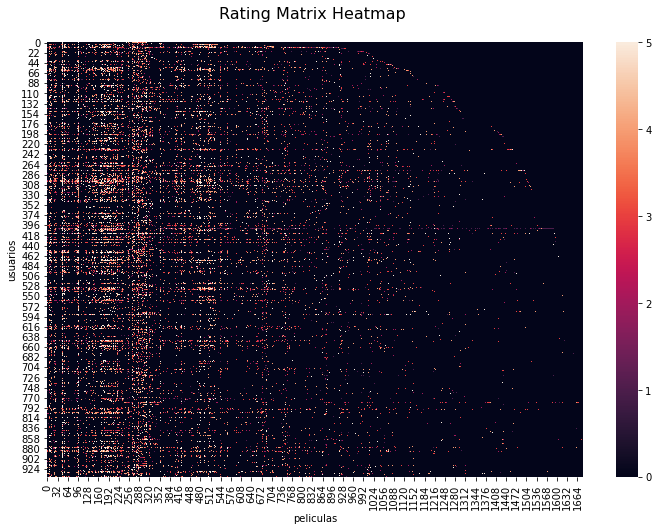

In [32]:
fig=plt.figure(figsize=(12,8))
sns.heatmap(R.T, vmin=0, vmax=5)
plt.title('Rating Matrix Heatmap \n', fontsize=16)
plt.xlabel('peliculas')
plt.ylabel('usuarios')

### Peliculas mas populares in Movielens 100K

Las columnas de la matrix R ya se encuentran ordenadas por popularidad de peliculas

In [34]:
print('cantidad de usuarios que vieron cada pelicula', np.sum(Rbinary, axis = 1))

cantidad de usuarios que vieron cada pelicula [452 131  90 ...   1   1   1]


In [36]:
print(movie_names[0:10])

0                                      Toy Story(1995)
1                                      GoldenEye(1995)
2                                     Four Rooms(1995)
3                                     Get Shorty(1995)
4                                        Copycat(1995)
5    Shanghai Triad(Yao a yao yao dao waipo qiao)(1...
6                                 Twelve Monkeys(1995)
7                                           Babe(1995)
8                               Dead Man Walking(1995)
9                                    Richard III(1995)
Name: 1, dtype: object


**Tarea**: Convierte los datos tabulares de Movielens de la *clase 1* a una matrix $R$ de usuarios y peliculas

Ayuda: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html

### **Extra**: Visualizacion con WordClouds (Nubes de palabras)

In [37]:
!pip install wordcloud

In [40]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [48]:
C = np.sum(Rbinary, axis = 1)
text = ''
for i, movie in enumerate(movie_names):
  text += movie * C[i]

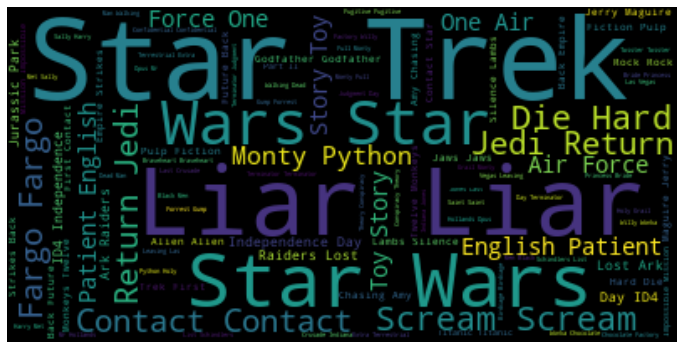

In [50]:
fig=plt.figure(figsize=(12,8))
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()